## IMPORT LIBRARY

In [33]:
# Core
import os
from pathlib import Path
from glob import glob
import numpy as np
import pickle

# Image Processing
import cv2

# Feature Extraction
from skimage.feature import hog, local_binary_pattern

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

## LOAD DATASET

In [34]:
def get_dataset_paths():
    base_path = Path.cwd() / "dataset"

    ai_path = base_path / "AI Image"
    real_path = base_path / "Real Image"

    if not ai_path.exists() or not real_path.exists():
        raise FileNotFoundError(
            f"Folder dataset tidak ditemukan!\n"
            f"AI Path   : {ai_path}\n"
            f"Real Path : {real_path}"
        )

    return ai_path, real_path

In [35]:
def load_image_paths(folder_path):
    return sorted(glob(str(folder_path / "*")))

ai_path, real_path = get_dataset_paths()

ai_images = load_image_paths(ai_path)
real_images = load_image_paths(real_path)

print(f"Jumlah AI Images   : {len(ai_images)}")
print(f"Jumlah Real Images : {len(real_images)}")

Jumlah AI Images   : 400
Jumlah Real Images : 400


## PREPROCESSING IMAGE

In [36]:
def preprocess_images(image_paths, label, size=(128, 128)):

    gray_images = []
    rgb_images = []
    labels = []

    for path in image_paths:
        img = cv2.imread(path)
        if img is None:
            continue

        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_rgb = cv2.resize(img_rgb, size)
        img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

        rgb_images.append(img_rgb)
        gray_images.append(img_gray)
        labels.append(label)

    return gray_images, rgb_images, labels

ai_gray, ai_rgb, ai_labels = preprocess_images(ai_images, label=1)
real_gray, real_rgb, real_labels = preprocess_images(real_images, label=0)

## FEATURE EXTRACTION

**RGB Histogram**

In [37]:
def extract_rgb_histogram(images, bins=32):
    features = []
    for img in images:
        hist = []
        for i in range(3):
            h = cv2.calcHist([img], [i], None, [bins], [0,256])
            hist.extend(cv2.normalize(h, h).flatten())
        features.append(hist)
    return np.array(features)

**HOG**

In [38]:
def extract_hog(images):
    return np.array([
        hog(img, orientations=9, pixels_per_cell=(8,8),
            cells_per_block=(2,2), block_norm='L2-Hys')
        for img in images
    ])

**LBP**

In [39]:
def extract_lbp(images):
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        lbp = local_binary_pattern(gray, 24, 3, method='uniform')
        hist,_ = np.histogram(lbp.ravel(), bins=26, range=(0,26))
        features.append(hist / (hist.sum() + 1e-6))
    return np.array(features)

## PIPELINE FEATURE FUSION

In [40]:
def build_features(use_rgb=True, use_hog=True, use_lbp=True):
    X = []

    if use_rgb:
        X.append(extract_rgb_histogram(ai_rgb + real_rgb))
    if use_lbp:
        X.append(extract_lbp(ai_rgb + real_rgb))
    if use_hog:
        X.append(extract_hog(ai_gray + real_gray))

    return np.hstack(X)

In [41]:
X = build_features(use_rgb=True, use_hog=False, use_lbp=False)
y = np.array(ai_labels + real_labels)

print("Final feature shape:", X.shape)

Final feature shape: (800, 96)


## TRAINING & EVALUATION

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42
)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred, target_names=["Real","AI"]))

              precision    recall  f1-score   support

        Real       0.80      0.81      0.81        80
          AI       0.81      0.80      0.81        80

    accuracy                           0.81       160
   macro avg       0.81      0.81      0.81       160
weighted avg       0.81      0.81      0.81       160



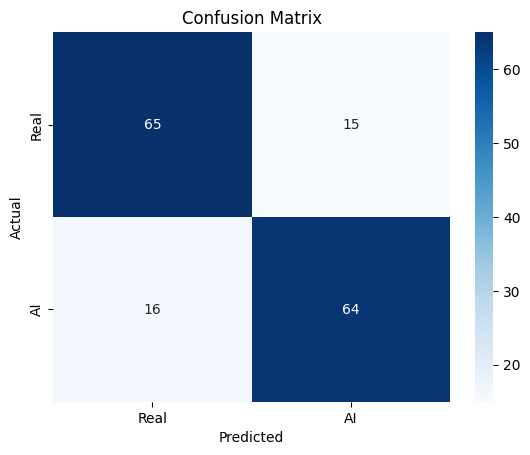

In [43]:
# Confusion Matrix
sns.heatmap(
    confusion_matrix(y_test, y_pred),
    annot=True, fmt='d',
    xticklabels=["Real","AI"],
    yticklabels=["Real","AI"],
    cmap="Blues"
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

## SIMPAN MODEL

In [45]:
filename = "random_forest_ai_vs_real_model.sav"

with open(filename, "wb") as file:
    pickle.dump(model, file)

print(f"Model berhasil disimpan sebagai {filename}")

Model berhasil disimpan sebagai random_forest_ai_vs_real_model.sav
